In [25]:
library(dplyr)
library(ggplot2)
library(party)
library(arules)
library(neuralnet)
library(zoo)
library(reshape2)
library(anytime)

# Import all required data
games <- read.csv('../input/games.csv', header = T)


In [26]:
# Convert epoch time of date created 
games$creationTime <- games$creationTime/1000
games$creationTime <- anytime(games$creationTime)

# Simple conversion of game duration into minutes
games$gameDuration <-  round(games$gameDuration/60)

# Drop non-relevant columns
games$gameId <- NULL

#Drop games that are less than 15 minutes long
games <- games[which(games$gameDuration > 5),]
games <- games[which(games$firstTower > 0),]

# View fully accessible data
(games)

,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,⋯,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
1,2017-09-01 15:24:17,32,9,1,2,1,1,1,1,2,⋯,5,0,0,1,1,114,67,43,16,51
2,2017-06-19 05:06:43,31,9,1,1,1,1,0,1,1,⋯,2,0,0,0,0,11,67,238,51,420
3,2017-09-02 13:48:23,25,9,1,2,1,1,1,2,0,⋯,2,0,0,1,0,157,238,121,57,28
4,2017-09-02 10:35:03,29,9,1,1,1,1,1,1,0,⋯,0,0,0,0,0,164,18,141,40,51
5,2017-09-04 19:46:50,35,9,1,2,1,1,1,1,0,⋯,3,0,0,1,0,86,11,201,122,18
6,2017-08-02 09:59:52,34,9,1,2,2,1,1,2,0,⋯,6,0,0,3,0,119,134,154,63,31
7,2017-08-22 19:27:45,33,9,1,1,2,1,1,1,1,⋯,2,0,0,0,0,75,42,31,40,429
8,2017-09-03 20:59:23,22,9,1,1,1,0,0,2,1,⋯,0,0,0,2,0,157,38,122,40,238
9,2017-08-25 18:42:57,23,9,2,2,2,2,0,2,2,⋯,8,1,0,2,1,28,51,53,157,40
10,2017-09-02 20:58:38,45,9,2,2,2,2,2,2,0,⋯,8,3,1,2,0,64,141,84,67,53


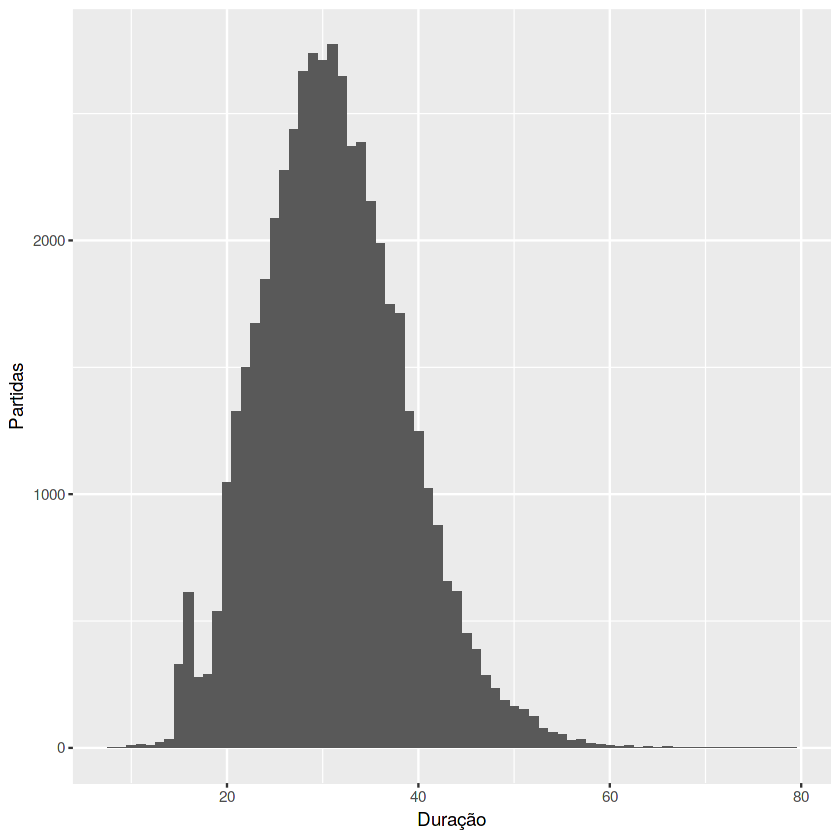

In [28]:
#Visualize average length of game
ggplot(games, aes(x=gameDuration)) + geom_histogram(binwidth = 1)+ 
  scale_y_continuous(name= "Partidas") +
  scale_x_continuous(name = "Duração") 

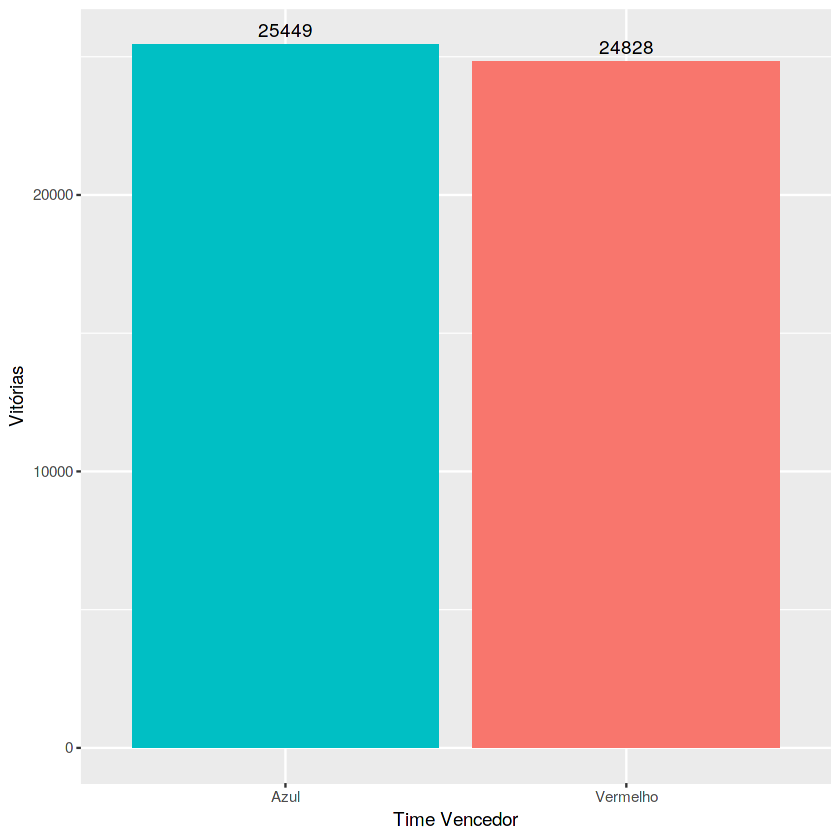

In [29]:
ggames <- games
ggames[,4:10][ggames[,4:10] == 0] <- 3
ggames[,4:10] <- sapply(ggames[,4:10], factor)

#View win rates
wr <- ggplot(ggames, aes(winner, fill = winner) ) +
  geom_bar() + geom_text(stat='count',aes(label=..count..),vjust=-0.5) +
  scale_fill_manual(values=c("#00BFC4", "#F8766D")) +
  scale_y_continuous(name= "Vitórias") +
  scale_x_discrete(name = "Time Vencedor", labels = c('Azul','Vermelho')) 
  wr + theme(legend.position="none")

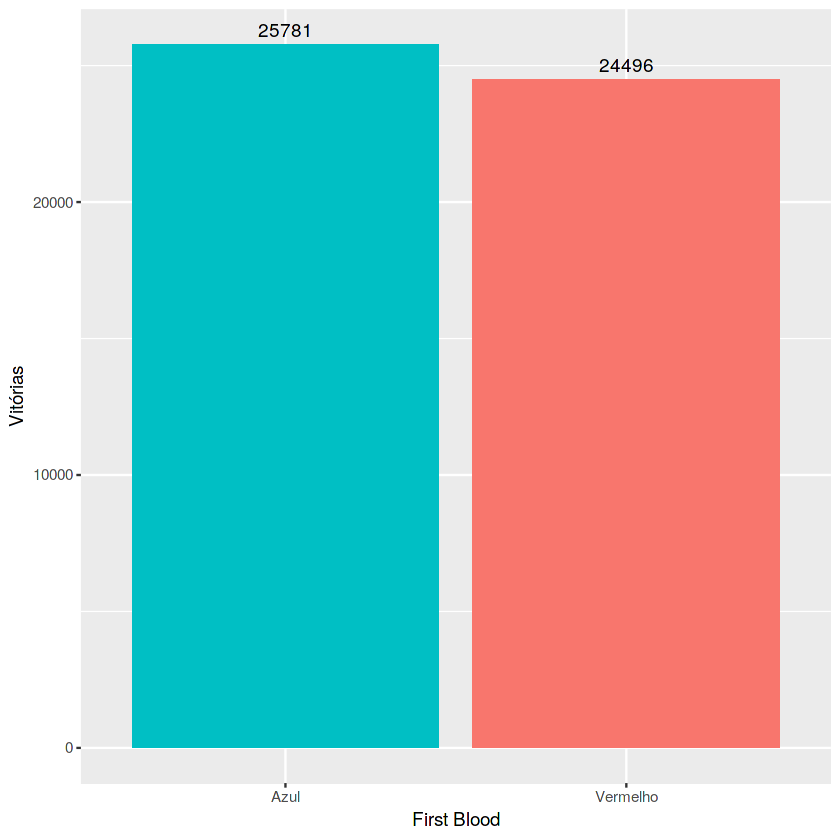

In [30]:
#View fb rates
fb <- ggplot(ggames, aes(firstBlood, fill = firstBlood)) +
  geom_bar() + geom_text(stat='count',aes(label=..count..),vjust=-0.5) +
  scale_fill_manual(values=c("#00BFC4", "#F8766D", "#D3D3D3")) +
  scale_y_continuous(name= "Vitórias") +
  scale_x_discrete(name = "First Blood", labels = c('Azul','Vermelho')) 
  fb + theme(legend.position="none")

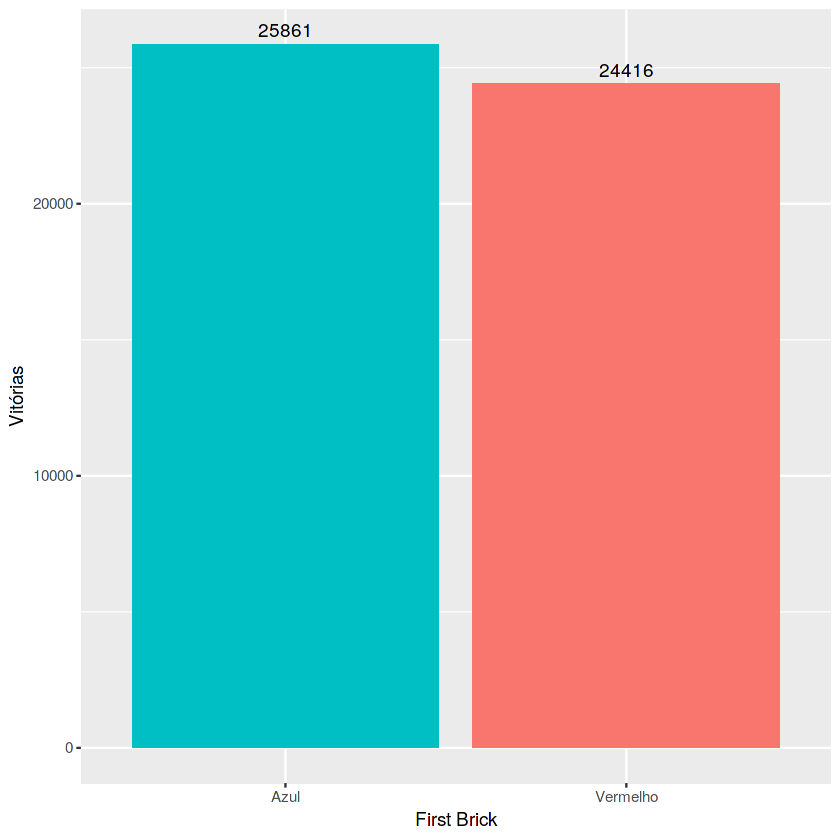

In [31]:
#View ft rates
ft <- ggplot(ggames, aes(firstTower, fill = firstTower  ) ) +
  geom_bar() + geom_text(stat='count',aes(label=..count..),vjust=-0.5) +
  scale_fill_manual(values=c("#00BFC4", "#F8766D", "#D3D3D3")) +
  scale_y_continuous(name= "Vitórias") +
  scale_x_discrete(name = "First Brick", labels = c('Azul','Vermelho')) 
  ft + theme(legend.position="none")

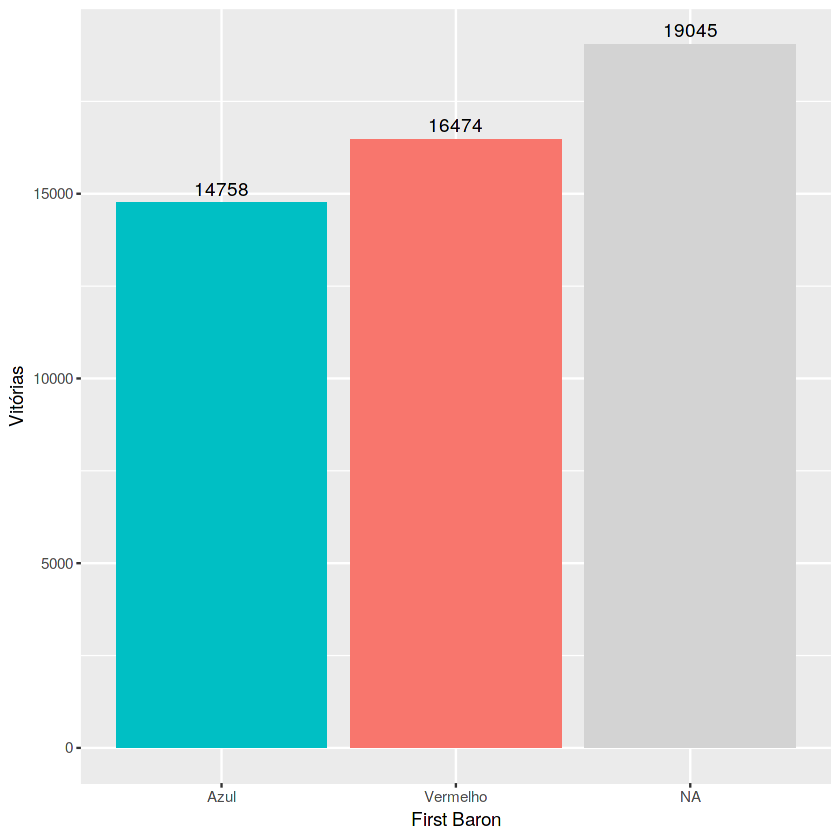

In [57]:
fba <- ggplot(ggames, aes(firstBaron, fill = firstBaron  ) ) +
  geom_bar() + geom_text(stat='count',aes(label=..count..),vjust=-0.5) +
  scale_fill_manual(values=c("#00BFC4", "#F8766D", "#D3D3D3")) +
  scale_y_continuous(name= "Vitórias") +
  scale_x_discrete(name = "First Baron", labels = c('Azul','Vermelho')) 
  fba + theme(legend.position="none")

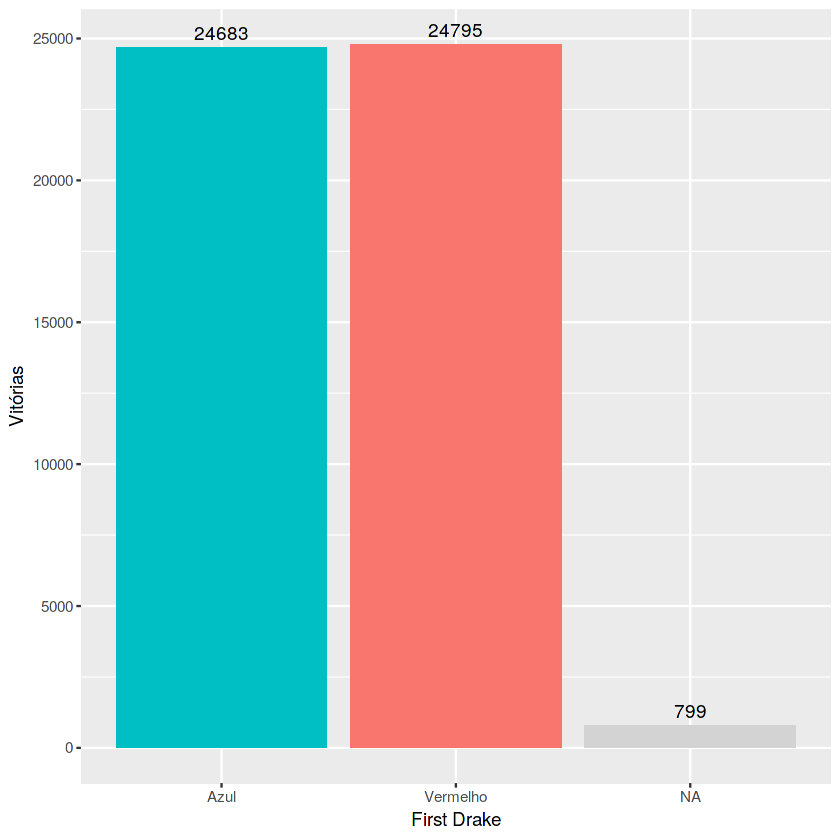

In [44]:
#View fd rates
fd <- ggplot(ggames, aes(firstDragon, fill = firstDragon  ) ) +
  geom_bar() + geom_text(stat='count',aes(label=..count..),vjust=-0.5) +
  scale_fill_manual(values=c("#00BFC4", "#F8766D", "#D3D3D3")) +
  scale_y_continuous(name= "Vitórias") +
  scale_x_discrete(name = "First Drake", labels = c('Azul','Vermelho')) 
  fd + theme(legend.position="none")

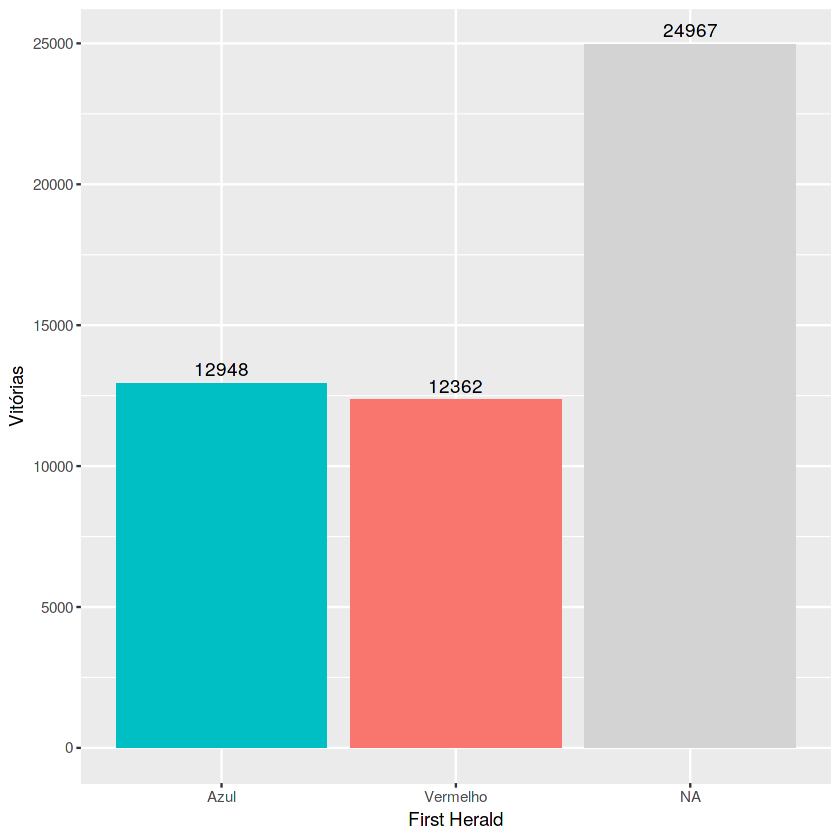

In [58]:
#View fd rates
fd <- ggplot(ggames, aes(firstRiftHerald, fill = firstRiftHerald  ) ) +
  geom_bar() + geom_text(stat='count',aes(label=..count..),vjust=-0.5) +
  scale_fill_manual(values=c("#00BFC4", "#F8766D", "#D3D3D3")) +
  scale_y_continuous(name= "Vitórias") +
  scale_x_discrete(name = "First Herald", labels = c('Azul','Vermelho')) 
  fd + theme(legend.position="none")
